One of the mainstay algorithms in machine learning is reinforcement learning (or *RL* for short). RL is an approach to machine learning that is used to teach an agent how to make decisions. The agent learns to achieve a goal in an uncertain, potentially complex environment. It learns by interacting with the environment and receiving feedback in the form of rewards or penalties. It then uses this feedback to learn the best strategy for achieving its goal.

It is a form of learning which is inspired by the way that humans and animals learn. For example, when a child learns to walk, they try to stand up, take a step, and fall down. They then learn from this experience and try again. Over time, they learn to walk by trial and error. It has many practical applications where we want to learn from the environment, such as robotics, self-driving cars or game playing.

## Connect Four

[Connect Four](https://en.wikipedia.org/wiki/Connect_Four) is a two-player connection game in which the players first choose a color and then take turns dropping colored discs from the top into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs.

It is a "solved game", meaning that with perfect play from both players, the first player can always win by playing the right moves.

In this experiment, we will use reinforcement learning to train an agent to play Connect Four. The agent will learn to play the game by playing against a "semi-intelligent" opponent, the adversary will play randomly, unless it can win or block in the next move. This was a design choice to make the implementation simpler, as our focus is on the reinforcement learning process, not the game playing skill.

## Gymnasium and Stable Baselines

We will be using the [Gymnasium library](https://gymnasium.farama.org), which is a collection of environments for training reinforcement learning agents. It is built on top of the [OpenAI Gym](https://gym.openai.com/) library. We will also be using the [Stable Baselines](https://stable-baselines.readthedocs.io/en/master/) library, which is a set of high-quality implementations of RL algorithms.

There is also [Petting Zoo](https://pettingzoo.farama.org), but it is used primarily for multi-agent RL, which is not what we are focusing on in this experiment.


### The rule set

We first need to create the rules and board for the RL agent to play against. It is the simulated environment the agent will learn from. Keep in mind that in RL, there is no *a priori* knowledge of the rules of the game, the agent learns solely by interacting with the environment.

Interactions with the environment follow three main information points:

1. The current state of the environment.
2. The action the agent takes.
3. The reward the agent receives.

The agent will learn to maximize the reward it receives by taking the best action in a given state.


``` {mermaid}
graph TD
    A(Agent)
    B(((Environment)))
    
    A -- Action --> B
    B -- State --> A
    B -- Reward --> A

    style B fill:#ffcccc,stroke:#ff0000,stroke-dasharray:5,5

    linkStyle 0 stroke:#1f77b4,stroke-width:2px      %% Action arrow in blue
    linkStyle 1 stroke:#2ca02c,stroke-dasharray:5,5,stroke-width:2px  %% State arrow in green dashed
    linkStyle 2 stroke:#d62728,stroke-dasharray:3,3,stroke-width:2px  %% Reward arrow in red dashed
```


Looking at the board and rules of Connect Four, we implement a number of functions to keep track of the game state (`drop_piece`, `check_win`, `is_board_full`, etc.). We also implement a function which is used for the adversary to play against the agent (`adversary_move`). Our adversary will play randomly, unless it can win the game in the next move, *or* it can block the agent from winning in the next move.


In [1]:
ROW_COUNT = 6
COLUMN_COUNT = 7

def drop_piece(board, row, col, piece):
    board[row][col] = piece

def check_win(board, piece):
    # Horizontal
    for r in range(ROW_COUNT):
        for c in range(COLUMN_COUNT - 3):
            if all(board[r][c+i] == piece for i in range(4)):
                return True
    # Vertical
    for c in range(COLUMN_COUNT):
        for r in range(ROW_COUNT - 3):
            if all(board[r+i][c] == piece for i in range(4)):
                return True
    # Positive diagonal
    for r in range(ROW_COUNT - 3):
        for c in range(COLUMN_COUNT - 3):
            if all(board[r+i][c+i] == piece for i in range(4)):
                return True
    # Negative diagonal
    for r in range(3, ROW_COUNT):
        for c in range(COLUMN_COUNT - 3):
            if all(board[r-i][c+i] == piece for i in range(4)):
                return True
    return False

def is_board_full(board):
    return all(board[0][c] != 0 for c in range(COLUMN_COUNT))

def get_next_open_row(board, col):
    for r in range(ROW_COUNT-1, -1, -1):
        if board[r][col] == 0:
            return r
    return -1

def is_valid_location(board, col):
    return board[0][col] == 0

def adversary_move(board, random):
    # First, check for a winning move for the adversary (piece = 2)
    for col in range(COLUMN_COUNT):
        if is_valid_location(board, col):
            temp_board = board.copy()
            row = get_next_open_row(temp_board, col)
            drop_piece(temp_board, row, col, 2)
            if check_win(temp_board, 2):
                return col
    # If no winning move, block the agent's winning move (piece = 1)
    for col in range(COLUMN_COUNT):
        if is_valid_location(board, col):
            temp_board = board.copy()
            row = get_next_open_row(temp_board, col)
            drop_piece(temp_board, row, col, 1)
            if check_win(temp_board, 1):
                return col
    # Otherwise, choose a random valid column using the provided random generator.
    valid_cols = [c for c in range(COLUMN_COUNT) if is_valid_location(board, c)]
    return random.choice(valid_cols) if valid_cols else None

## The environment

Now that we have a rule set for Connect Four, we need to create an environment for the agent to interact with. The environment is a class which implements the necessary methods required by the Gymnasium `Env` class. These methods include `reset` (to bring the board and playing environment to an initial state) and `step` (to take an action and return the new state, reward, and whether the game is over).

During the initialization of the environment, we also create an *observation space* and an *action space*. The observation space is the state of the environment (our 6x7 Connect Four board), and the action space are the possible actions the agent can take - in this case, the columns in which the agent can drop a piece (a discreet set of values between 0 and 6).


In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random

class ConnectFourEnv(gym.Env):
    def __init__(self):
        super(ConnectFourEnv, self).__init__()
        self.action_space = spaces.Discrete(COLUMN_COUNT)
        # The board is 6x7 with values: 0 (empty), 1 (agent), 2 (computer)
        self.observation_space = spaces.Box(low=0, high=2, shape=(ROW_COUNT, COLUMN_COUNT), dtype=np.int8)
        self.reset()

    def reset(self, seed=None, options=None):
        # If self.board exists, copy it to self.last_board
        if hasattr(self, "board"):
            self.last_board = self.board.copy()
        self.board = np.zeros((ROW_COUNT, COLUMN_COUNT), dtype=np.int8)
        self.done = False
        return self.board.copy(), {}

    def seed(self, seed=None):
        self.random = random.Random(seed)
        return [seed]

    def step(self, action):
        if not is_valid_location(self.board, action):
            # Return invalid move penalty
            return self.board.copy(), -10, True, False, {"error": "Invalid move"}
        
        # Check if board is full
        if is_board_full(self.board):
            return self.board.copy(), 0, True, False, {}

        # Agent's move (piece = 1)
        row = get_next_open_row(self.board, action)
        drop_piece(self.board, row, action, 1)
        if check_win(self.board, 1):
            return self.board.copy(), 1, True, False, {"winner": 1}

        # Adversary's move (piece = 2)
        comp_action = adversary_move(self.board, self.random)
        if comp_action is not None:
            row = get_next_open_row(self.board, comp_action)
            drop_piece(self.board, row, comp_action, 2)
            if check_win(self.board, 2):
                return self.board.copy(), -1, True, False, {"winner": 2}

        # No win or board full, continue the game.
        return self.board.copy(), 0, False, False, {}

    def render(self, mode='human'):
        pass

You will notice the `step` method returns a tuple of five values: the new state (the Connect Four board), the reward, if we have reached a terminal state, a truncation flag (which we will not use), and a dictionary of additional information (which we will also not use). For example, when the adversary moves and wins, we return a reward of -1, and the game is over (`return self.board.copy(), -1, True, False, {"winner": 2}`).

`step` also takes an action as an argument, which in our case is the column the agent wants to drop a piece into. Through RL it will learn to maximize the reward it receives by taking the best action in a given state.

Rewards in our environment are:

- +1 if the agent takes an action that leads to a win.
- -1 if the agent takes an action that leads to a loss.
- 0 if the agent takes an action that leads to a draw, or if the game is not over.
- -10 if the agent takes an action that leads to an invalid move.

Remember that the agent does not know the rules of the game, it learns solely by interacting with the environment.

::: {.callout-note}
## About Rewards

Rewards are a crucial part of reinforcement learning. They are used to guide the agent towards the desired behavior. In essence, rewards serve as the primary feedback mechanism that informs the agent whether its actions lead to favorable outcomes. Without a well-defined reward signal, an agent has no basis for discerning which behaviors are beneficial, making it nearly impossible to learn or optimize performance.

The design of rewards is just as important as their presence. A poorly designed reward structure can lead the agent astray, encouraging it to exploit loopholes or engage in unintended behaviors—a phenomenon known as reward hacking. For example, if an agent is rewarded only for reaching a goal, it might learn shortcuts that maximize reward without actually achieving the intended objective. To avoid such pitfalls, reward shaping is often employed. This technique involves carefully tuning the reward function to provide incremental feedback that nudges the agent in the right direction, while still preserving the overall objective.

Rewards directly influence the learning efficiency and stability of the training process. *Sparse* rewards, where feedback is infrequent, can make learning slow and challenging because the agent struggles to correlate actions with outcomes. Conversely, *dense* rewards provide frequent signals but can sometimes overwhelm the learning process if not managed properly.
:::

### Rendering the board

Often in reinforcement learning, we want to visualize the environment to see how the agent is performing. Gymnasium provides a `render` method that allows us to visualize the environment, but in our case, we will implement an ancillary function (`render_board_pygame_to_image`) which uses the [Pygame](https://www.pygame.org) library to render the board to an image. This function will be used to visualize the board further down.


In [3]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
import pygame

SQUARE_SIZE = 100

def render_board_pygame_to_image(board, title="Connect Four Board"):
    pygame.init()
    width = COLUMN_COUNT * SQUARE_SIZE
    height = (ROW_COUNT + 1) * SQUARE_SIZE
    # Create an offscreen surface
    surface = pygame.Surface((width, height))
    
    RADIUS = int(SQUARE_SIZE / 2 - 5)
    BLUE = (0, 0, 255)
    BLACK = (0, 0, 0)
    RED = (255, 0, 0)
    YELLOW = (255, 255, 0)
    
    # Draw board background
    for c in range(COLUMN_COUNT):
        for r in range(ROW_COUNT):
            rect = pygame.Rect(c * SQUARE_SIZE, r * SQUARE_SIZE + SQUARE_SIZE, SQUARE_SIZE, SQUARE_SIZE)
            pygame.draw.rect(surface, BLUE, rect)
            center = (int(c * SQUARE_SIZE + SQUARE_SIZE / 2),
                      int(r * SQUARE_SIZE + SQUARE_SIZE + SQUARE_SIZE / 2))
            pygame.draw.circle(surface, BLACK, center, RADIUS)
    
    # Draw the pieces
    for c in range(COLUMN_COUNT):
        for r in range(ROW_COUNT):
            piece = board[r][c]
            pos_x = int(c * SQUARE_SIZE + SQUARE_SIZE / 2)
            pos_y = height - int((r + 0.5) * SQUARE_SIZE)
            if piece == 1:
                pygame.draw.circle(surface, RED, (pos_x, pos_y), RADIUS)
            elif piece == 2:
                pygame.draw.circle(surface, YELLOW, (pos_x, pos_y), RADIUS)
    
    # Convert the surface to a NumPy array
    image_data = pygame.surfarray.array3d(surface)
    image_data = np.transpose(image_data, (1, 0, 2))[::-1]
    pygame.display.quit()
    return image_data

## Training the agent

We now have a rule set, a board and an adversary which our agent can play against. We now need to create a training loop for the agent to learn how to play Connect Four. We will use the Stable Baselines library to train the agent using a Proximal Policy Optimization (PPO) algorithm.

Stable Baselines offers a number of RL algorithms, such as [Proximal Policy Optimization](https://openai.com/index/openai-baselines-ppo/), [Deep Q-Networks](https://huggingface.co/learn/deep-rl-course/en/unit3/deep-q-algorithm) (DQN), and others. We will use PPO, as it is a simple and effective algorithm for training agents in environments with discrete action spaces such as board games.

::: {.callout-note}
## About Proximal Policy Optimization (PPO)

In reinforcement learning, a policy is essentially the decision-making function that maps each state an agent encounters to a probability distribution over possible actions. Think of it as the agent's strategy — its playbook. The policy determines how the agent behaves by indicating which actions are more likely to lead to favorable outcomes. This policy is typically parameterized using neural networks, allowing it to handle complex environments and adapt over time as it learns from experience.

Proximal Policy Optimization is an on-policy method that directly optimizes this policy to maximize expected *cumulative* rewards. Instead of first learning value functions and then deriving a policy (as in value-based methods), PPO updates the policy itself. It does this by collecting trajectories from the current policy and computing advantage estimates that quantify how much better one action is over another in a given state. The core difference in PPO is its use of a clipped surrogate objective function. This objective calculates a ratio between the probability of taking an action under the new policy versus the old policy. By clipping this ratio within a set range, PPO prevents overly large updates that could destabilize learning, effectively ensuring that each update is a small, safe step toward improvement.

This balancing act — improving the policy while preventing drastic shifts — allows PPO to be both efficient and robust. The clipping mechanism maintains a trust region implicitly, similar to what more complex methods like Trust Region Policy Optimization (TRPO) enforce explicitly. As a result, PPO has become popular for its simplicity, ease of tuning, and good performance across a variety of reinforcement learning tasks.
:::

### Multi-processing

Stable Baselines can operate in parallel, using multiple CPU cores to speed up training. We do this by creating multiple environments and running them in parallel. This is done with the Stable Baselines `SubprocVecEnv` method, which takes a list of environments, which it then parallelizes.

### Model hyperparameters

For our PPO model, we need to define a number of hyperparameters. These include the number of steps (or actions) the agent will take in the environment during training, the learning rate, the number of epochs, and the number of steps to take before updating the model.

When creating the model with the `PPo` method, we set a number of hyperparameters. First off, `MlpPolicy` tells the model to use a Multi-Layer Perceptron as the underlying neural network architecture. This choice is typical when working with environments where the observations can be flattened into a vector and don’t require specialized structures like convolutional layers.

The `learning_rate=0.0001` determines the step size in the optimization process; a smaller learning rate like this one leads to more stable but slower convergence, helping to avoid drastic changes that might destabilize learning. The appropriate value depends on the specific environment and task, and tuning it is often an iterative process.

`n_steps=500` specifies the number of time steps to collect from each environment before performing a model update (i.e., updating the weights on our MLP network). This collection phase is vital in on-policy algorithms like PPO since it defines the size of the batch of experience data. In the case of a game like Connect Four, we want to collect enough actions to capture a few games - since the maximum number of steps in a 6x7 board is 42, 500 steps should capture at least 12 games (but likely many more) before the model is updated.

After collecting these experiences, the `batch_size=64` parameter determines the size of the mini-batches used during the gradient descent updates - this hyperparameter is difficult to tune, but here we set it to a multiple of the number of environments times the number of steps.

Finally, `n_epochs=10` indicates that for each batch of collected data, the optimization process will iterate over the entire batch 10 times. This repeated pass helps in extracting as much learning signal as possible from the collected data, although it needs to be balanced to avoid overfitting to the current batch of experiences.


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.logger import configure
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed

rnd_seed = 42

# Function to create a new environment instance
def make_env(id, seed=rnd_seed):
    def _init():
        env = ConnectFourEnv()
        env.seed(seed + id)
        return env
    set_random_seed(seed)
    return _init

# Number of parallel environments
n_cpu = 12
env = SubprocVecEnv(
    [make_env(i) for i in range(n_cpu)]
)

log_dir = "/tmp/connect4/"
new_logger = configure(log_dir, ["csv"])

model = PPO(
    "MlpPolicy",
    env,
    verbose=0,
    learning_rate=0.0001,
    n_steps=500,       # n_steps per environment
    batch_size=64,
    n_epochs=10
)

model.set_logger(new_logger)

# total_timesteps is the sum across all environments
model = model.learn(total_timesteps=12000000, progress_bar=True)

Output()

When training the model, we set a `total_timesteps` of 12,000,000 - this is the total number of actions the agent will take in the environment during training, *not* the number of Connect Four games it should complete. If we assume an average number of 21 moves per completed game, we would be training on approximately 570,000 games.

## Metric evaluation

Now that we have the RL training loop complete, we can look at the metrics gathered during training. We will look at the training, entropy and value losses specifically, but there are many more metrics we can track.


In [5]:
import pandas as pd

df = pd.read_csv(f"{log_dir}/progress.csv")
print(df.columns)

Index(['time/fps', 'time/iterations', 'time/total_timesteps',
       'time/time_elapsed', 'train/value_loss', 'train/explained_variance',
       'train/n_updates', 'train/loss', 'train/learning_rate',
       'train/approx_kl', 'train/clip_range', 'train/entropy_loss',
       'train/clip_fraction', 'train/policy_gradient_loss'],
      dtype='object')


Let us plot a few selected training metrics to evaluate how the agent performed while learning to play Connect Four.


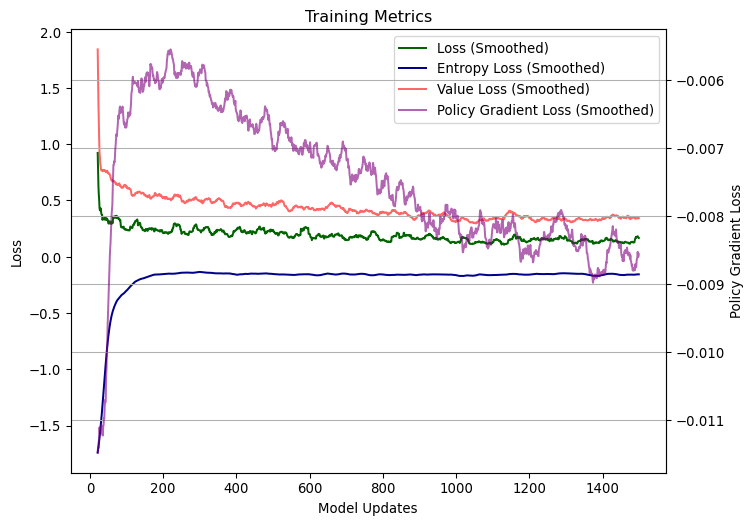

In [6]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the main losses on the primary axis (left-hand side)
ax1.plot(df["train/loss"].rolling(window=21).mean(), label="Loss (Smoothed)", color='darkgreen')
ax1.plot(df["train/entropy_loss"].rolling(window=21).mean(), label="Entropy Loss (Smoothed)", color='darkblue')
ax1.plot(df["train/value_loss"].rolling(window=21).mean(), label="Value Loss (Smoothed)", color='red', alpha=0.6)
ax1.set_xlabel("Model Updates")
ax1.set_ylabel("Loss")

# Create a secondary axis for policy gradient loss
ax2 = ax1.twinx()
ax2.plot(df["train/policy_gradient_loss"].rolling(window=21).mean(), 
            label="Policy Gradient Loss (Smoothed)", color='purple', alpha=0.6)
ax2.set_ylabel("Policy Gradient Loss")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title("Training Metrics")
plt.grid(True)
plt.show()

The "Loss" is a measure of how well the model is performing, it is the overall loss function that the algorithm minimizes during training. In PPO, this loss is typically a combination of several components: the policy gradient loss, the value function loss, and an entropy bonus (to encourage exploration). Essentially, it's a weighted sum of these parts that drives the updates to your model's parameters.

"Entropy Loss" is related to the entropy bonus added to the loss function. In reinforcement learning, encouraging a certain level of randomness (or exploration) in the policy is beneficial to avoid premature convergence to a suboptimal policy. A higher entropy generally means the agent's decisions are more varied. In practice, the entropy loss is often implemented as a negative value so that higher entropy reduces the total loss, nudging the agent to explore more.

"Value Loss" measures the error in the value function estimation. The value loss is usually calculated as the mean squared error between the predicted values (expected returns) and the actual returns obtained from the environment. A lower value loss indicates that the critic (value estimator) is accurately predicting the future rewards, which is important for guiding the policy updates.

Finally, "Policy Gradient Loss" reflects the loss associated with the policy gradient component of PPO. It arises from the surrogate objective, which in PPO is clipped to prevent large deviations from the old policy. This clipping ensures that updates remain within a "trust region," promoting stable and incremental improvements. Monitoring this metric can help you understand how effectively your policy is being updated and if the clipping mechanism is keeping the changes in check.

::: {.callout-note}
## About Actor-Critic Methods

Imagine you're playing a game. The actor is like the player making moves, and the critic is like a coach who watches the game and gives advice. The critic’s job is to figure out how promising the current situation is — it predicts the future score if you follow a certain strategy.

The critic does this by looking at the current state of the game and outputting a single number, which represents the expected future rewards. Essentially giving a "score" for that state. During training, the critic compares its predicted score to the actual outcome, learns from any mistakes, and updates its estimates so it becomes better at predicting future rewards.

The critic provides feedback to the actor by saying, "Based on this situation, your choice might lead to a high score (or a low one)." This feedback helps the actor adjust its moves to maximize rewards, much like a coach helping a player improve their game strategy.
:::

The following diagram shows the relationship between the actor and critic in an actor-critic method:


``` {mermaid}

graph TD
    A(Actor - Policy Network)
    B(((Environment)))
    C[Critic - Value Network]
    D[Advantage Estimation]
    E[Policy Update]
    
    A -- "Action" --> B
    B -- "State/Reward" --> C
    C -- "Compute Advantage" --> D
    D -- "Policy Gradient Update" --> E
    E -- "New Policy" --> A

    style B fill:#ffcccc,stroke:#ff0000,stroke-dasharray:5,5

    linkStyle 0 stroke:#1f77b4,stroke-width:2px
    linkStyle 1 stroke:#2ca02c,stroke-dasharray:5,5,stroke-width:2px
    linkStyle 2 stroke:#d62728,stroke-dasharray:3,3,stroke-width:2px
    linkStyle 3 stroke:#9467bd,stroke-width:2px
    linkStyle 4 stroke:#8c564b,stroke-dasharray:5,5,stroke-width:2px
```


## Evaluating the trained agent

Now that we have completed training the agent, we can evaluate its performance by playing against the adversary. To do so, we will play 100 games ("episodes" in RL parliance) and record the results.

We will `reset` the environment we created before, and then `step` through the environment using the trained model to take actions - each action (or step) will be the column the agent wants to drop a piece into. We will then loop through the game, making further predictions, until it is over, and record the overal results.

Because the environment is running in parallel, `actions, _ = model.predict(obs, deterministic=True)` returns a list of predicted actions for each parallel environment. We then loop through the environments, taking the action for each, and then calling `env.step` with the model's chosen action to get the next state, reward, and if the game is over or if it should continue.


In [7]:
num_episodes = 100
results = {'win': 0, 'loss': 0, 'draw': 0}
games_finished = 0

obs = env.reset()

final_boards = []
done_count = 0

while games_finished < num_episodes:
    actions, _ = model.predict(obs, deterministic=True)
    obs, rewards, dones, infos = env.step(actions)

    # Process each finished environment instance.
    for i, done in enumerate(dones):
        if done:
            done_count += 1
            final_boards.append(infos[i]['terminal_observation'])
            r = rewards[i]
            if r == 1:
                results['win'] += 1
            elif r == -1:
                results['loss'] += 1
            else:
                results['draw'] += 1
            games_finished += 1
            if games_finished >= num_episodes:
                break

With the evaluation complete, we can plot the results to see how the agent performed against the adversary.


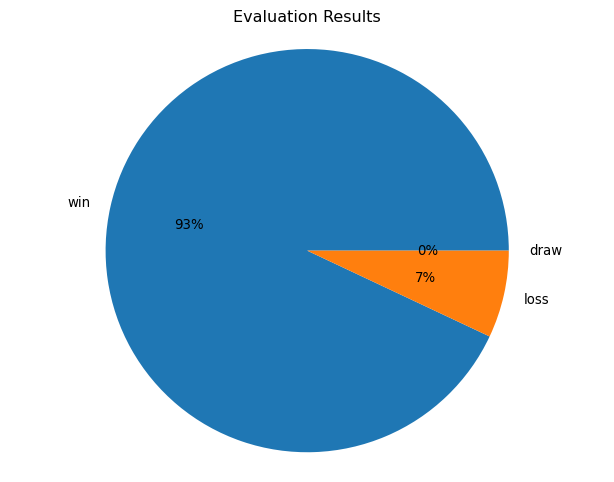

In [8]:
plt.figure(figsize=(8, 6))
plt.pie(results.values(), labels=results.keys(), autopct='%1.0f%%')
plt.title("Evaluation Results")
plt.axis('equal')
plt.grid(True)
plt.show()

Given that the adversary plays randomly, unless it can win or block in the next move, we would expect the agent to win most games, as it should learn to play optimally over time. This is indeed what we see in the results, with the agent winning the vast majority of the games, very close to the theoretical 100% win rate (notice that the agent opens the game, so it should always win if it plays optimally).

## Visually inspecting some of the game boards

Finally, we can visually inspect some of the game boards to see how the agent played against the adversary. Let us render a sample of the final game boards using the `render_board_pygame_to_image` function we created earlier.


Yellow = Computer, Red = Agent


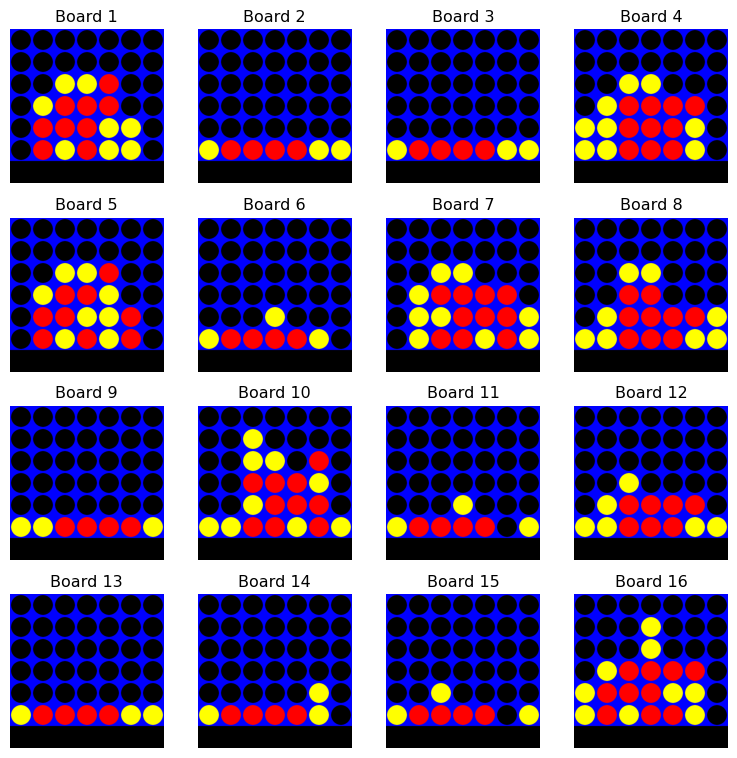

In [9]:
print("Yellow = Computer, Red = Agent")
# Randomly sample 16 final boards for the grid plot
selected_boards = random.sample(final_boards, 16)

# Plot these boards in a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, board in enumerate(selected_boards):
    img = render_board_pygame_to_image(board)
    ax = axs[i // 4, i % 4]
    ax.imshow(img)
    ax.set_title(f"Board {i + 1}")
    ax.axis("off")
plt.tight_layout()
plt.show()

## What's next?

Our RL trained agent achieved an high win rate, not far to the theoretical 100% win rate for an opening player. We could further improve the agent by training it against a perfect adversary, randomly selecting the starting player. This would allow the agent to experience both sides of the game and learn from a broader range of possible moves.
